In [461]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

In [462]:
data = pd.read_csv('cm_dataset.csv')
x, y = np.array(data.iloc[:, 0], dtype='float64'), np.array(data.iloc[:, 1], dtype='float64')
points = np.array([[x[i], y[i]] for i in range(len(x))]).T

num_clusters = 2
dimensions = 2
num_points = len(x)
iterations = 20
power = 2
sigma = 3.5
k = 2 # number of higher dimension
distant_point = np.array([1e9, 1e9])

In [463]:
def calculate_distance(point1, point2):
    return np.sqrt(np.sum((point1-point2)**2))

def kernelise(data, d):
    kernel_matrix = np.array([[(1+np.dot(data[:, i], data[:, j]))**d for j in range(data.shape[1])]for i in range(data.shape[1])])
    return kernel_matrix

def kernelise_rad(data, d):
    kernelised_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            diff = data[:, i] - data[:, j]
            kernelised_matrix[i, j] = np.exp(-(np.dot(diff, diff)/(2*(d**2))))

    return kernelised_matrix

def center_kernel_matrix(kernel_matrix):
    n = kernel_matrix.shape[0]
    one_n = np.ones((n, n))
    one_n /= n
    centered_kernel_matrix = kernel_matrix - np.dot(one_n, kernel_matrix) - np.dot(kernel_matrix, one_n) + np.dot(np.dot(one_n, kernel_matrix), one_n)
    epsilon = 5*1e-7
    centered_kernel_matrix += epsilon*np.eye(n)
    return centered_kernel_matrix

In [464]:
# kernelised_matrix = kernelise_rad(points, sigma)
kernelised_matrix = kernelise(points, power)
centered_kernel_matrix = center_kernel_matrix(kernelised_matrix)

In [465]:
eigen_values, eigen_vectors = np.linalg.eigh(centered_kernel_matrix)[0].real, np.linalg.eigh(centered_kernel_matrix)[1].real
descending_indices = np.argsort(eigen_values)[::-1]
eigen_values = eigen_values[descending_indices]
eigen_vectors = eigen_vectors[:, descending_indices].T

In [466]:
# confirms that all the eigen_values are positive.
print(eigen_values.min() >= 0)

True


In [467]:
print(eigen_vectors[:k].shape)
spectral_data = eigen_vectors[:k].T # Now this contains row-wise points and column-wise number of points.
normal_spectral_data = np.zeros((1000, k))
# This for loop is used to normalise data
for i, spectral_data_point in enumerate(spectral_data):
    normal_spectral_data[i] = spectral_data_point/np.linalg.norm(spectral_data_point)
spectral_data = spectral_data.T
normal_spectral_data = normal_spectral_data.T

(2, 1000)


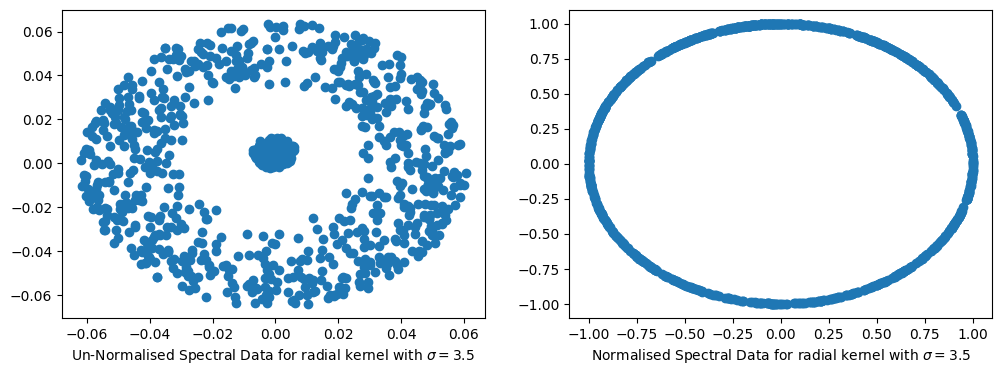

In [468]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(spectral_data[0], spectral_data[1])
ax[1].scatter(normal_spectral_data[0], normal_spectral_data[1])
ax[0].set_xlabel(r"Un-Normalised Spectral Data for radial kernel with $\sigma=$" + str(sigma))
ax[1].set_xlabel(r"Normalised Spectral Data for radial kernel with $\sigma=$" + str(sigma))
plt.show()

In [469]:
# this is for extra plotting.
#uncomment if you want to see for k = 3
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# ax.scatter(spectral_data[0], spectral_data[1], spectral_data[2])
# ax.tick_params(left=False, bottom=False, right=False, top=False, labelleft=False, labelbottom=False, labelright=True, labeltop=False)
# ax.set_title("Data for k=3 in 3d representation")
# plt.show()

In [470]:
z_unnormalised = np.random.randint(0, num_clusters, num_points)
# uncomment for k = 3
# z_unnormalised = np.array([int(spectral_data[2, i] > 0.04) for i in range(num_points)])
z_normalised = z_unnormalised

unnormalised_spectral_clusters = []
normalised_spectral_clusters = []
normalised_point_clusters = []
unnormalised_point_clusters = []

for i in range(num_clusters):
    unnormalised_spectral_clusters.append([[] for j in range(k)])
    normalised_spectral_clusters.append([[] for j in range(k)])
    normalised_point_clusters.append([[], []])
    unnormalised_point_clusters.append([[], []])

for i, spectral_data_point in enumerate(spectral_data.T):
    for d in range(k):
        normalised_spectral_clusters[z_normalised[i]][d].append(normal_spectral_data[d, i])
        unnormalised_spectral_clusters[z_unnormalised[i]][d].append(spectral_data_point[d])
    for d in range(2):
        unnormalised_point_clusters[z_unnormalised[i]][d].append(points[d, i])
        normalised_point_clusters[z_normalised[i]][d].append(points[d, i])

In [471]:
unnormalised_spectral_means = np.zeros((num_clusters, k), dtype='float64')
normalised_spectral_means = np.zeros((num_clusters, k), dtype='float64')
normalised_point_means = np.zeros((num_clusters, dimensions), dtype='float64')
unnormalised_point_means = np.zeros((num_clusters, dimensions), dtype='float64')

norm_num_cluster_points = np.zeros(num_clusters)
unnorm_num_cluster_points = np.zeros(num_clusters)

for i, spectral_data_point in enumerate(spectral_data.T):
    unnormalised_spectral_means[z_unnormalised[i]] += spectral_data_point
    normalised_spectral_means[z_normalised[i]] += normal_spectral_data[:, i]
    normalised_point_means[z_normalised[i]] += points[:, i]
    unnormalised_point_means[z_unnormalised[i]] += points[:, i]
    norm_num_cluster_points[z_normalised[i]] += 1

for i, spectral_mean in enumerate(unnormalised_spectral_means):
    if unnorm_num_cluster_points[i] == 0:
        spectral_mean = np.array([1e9 for _ in range(k)])
        unnormalised_point_means[i] = distant_point
    else:
        spectral_mean /= unnorm_num_cluster_points[i]
        unnormalised_point_means[i] /= unnorm_num_cluster_points[i]

for i, spectral_mean in enumerate(normalised_spectral_means):
    if norm_num_cluster_points[i] == 0:
        normalised_spectral_means[i] = np.array([1e9 for _ in range(k)])
        normalised_point_means[i] = distant_point
    else:
        normalised_spectral_means[i] /= norm_num_cluster_points[i]
        normalised_point_means[i] /= norm_num_cluster_points[i]

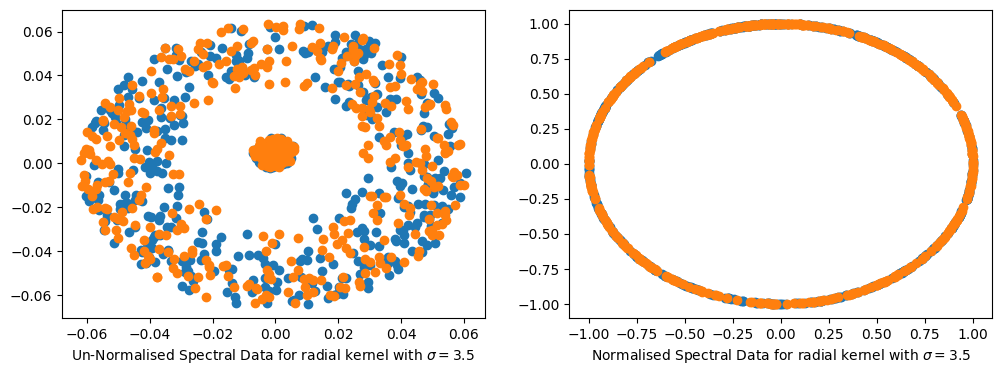

In [472]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for j in range(2):
    ax[0].scatter(unnormalised_spectral_clusters[j][0], unnormalised_spectral_clusters[j][1])
    ax[1].scatter(normalised_spectral_clusters[j][0], normalised_spectral_clusters[j][1])

ax[0].set_xlabel(r"Un-Normalised Spectral Data for radial kernel with $\sigma=$" + str(sigma))
ax[1].set_xlabel(r"Normalised Spectral Data for radial kernel with $\sigma=$" + str(sigma))

# plt.savefig('images/Q2/p3rad1')
plt.show()

In [473]:
# Uncomment if you are running for k=3
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# for i in range(num_clusters):
#     ax.scatter(unnormalised_spectral_clusters[i][0], unnormalised_spectral_clusters[i][1], unnormalised_spectral_clusters[i][2])
# ax.tick_params(left=False, bottom=False, right=False, top=False, labelleft=False, labelbottom=False, labelright=False, labeltop=False)
# ax.set_title("Data in 3d after natural clustering")
# plt.show()

In [474]:
def update_means(means, points, z):
    for i, point in enumerate(points.T):
        min_dist = calculate_distance(point, means[z[i]])
        for j, mean in enumerate(means):
            dist = calculate_distance(mean, point)
            if min_dist > dist:
                min_dist = dist
                z[i] = j

count = 0
while count < iterations:
    update_means(unnormalised_spectral_means, spectral_data, z_unnormalised)
    update_means(normalised_spectral_means, normal_spectral_data, z_normalised)

    unnormalised_spectral_means = np.zeros((num_clusters, k), dtype='float64')
    normalised_spectral_means = np.zeros((num_clusters, k), dtype='float64')
    normalised_point_means = np.zeros((num_clusters, dimensions), dtype='float64')
    unnormalised_point_means = np.zeros((num_clusters, dimensions), dtype='float64')

    norm_num_cluster_points = np.zeros(num_clusters)
    unnorm_num_cluster_points = np.zeros(num_clusters)

    for i, spectral_data_point in enumerate(spectral_data.T):
        unnormalised_spectral_means[z_unnormalised[i]] += spectral_data_point
        normalised_spectral_means[z_normalised[i]] += normal_spectral_data[:, i]
        normalised_point_means[z_normalised[i]] += points[:, i]
        unnormalised_point_means[z_unnormalised[i]] += points[:, i]
        norm_num_cluster_points[z_normalised[i]] += 1

    for i, spectral_mean in enumerate(unnormalised_spectral_means):
        if unnorm_num_cluster_points[i] == 0:
            spectral_mean = np.array([1e9 for _ in range(k)])
            unnormalised_point_means[i] = distant_point
        else:
            spectral_mean /= unnorm_num_cluster_points[i]
            unnormalised_point_means[i] /= norm_num_cluster_points[i]

    for i, spectral_mean in enumerate(normalised_spectral_means):
        if norm_num_cluster_points[i] == 0:
            normalised_spectral_means[i] = np.array([1e9 for _ in range(k)])
            normalised_point_means[i] = distant_point
        else:
            normalised_spectral_means[i] /= norm_num_cluster_points[i]
            normalised_point_means[i] /= norm_num_cluster_points[i]
    
    count += 1

In [475]:
final_unnormalised_spectral_clusters = []
final_normalised_spectral_clusters = []
final_normalised_point_clusters = []
final_unnormalised_point_clusters = []

for i in range(num_clusters):
    final_unnormalised_spectral_clusters.append([[] for j in range(k)])
    final_normalised_spectral_clusters.append([[] for j in range(k)])
    final_normalised_point_clusters.append([[], []])
    final_unnormalised_point_clusters.append([[], []])

for i, spectral_data_point in enumerate(spectral_data.T):
    for d in range(k):
        final_normalised_spectral_clusters[z_normalised[i]][d].append(normal_spectral_data[d, i])
        final_unnormalised_spectral_clusters[z_unnormalised[i]][d].append(spectral_data_point[d])
    for d in range(2):
        final_unnormalised_point_clusters[z_unnormalised[i]][d].append(points[d, i])
        final_normalised_point_clusters[z_normalised[i]][d].append(points[d, i])

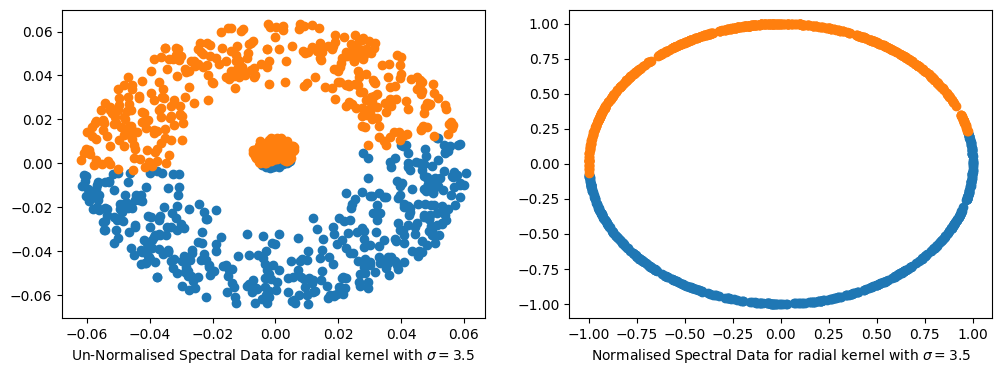

In [476]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for j in range(2):
    ax[0].scatter(final_unnormalised_spectral_clusters[j][0], final_unnormalised_spectral_clusters[j][1])
    ax[1].scatter(final_normalised_spectral_clusters[j][0], final_normalised_spectral_clusters[j][1])

ax[0].set_xlabel(r"Un-Normalised Spectral Data for radial kernel with $\sigma=$" + str(sigma))
ax[1].set_xlabel(r"Normalised Spectral Data for radial kernel with $\sigma=$" + str(sigma))
# plt.savefig('images/Q2/p3rad2')
plt.show()

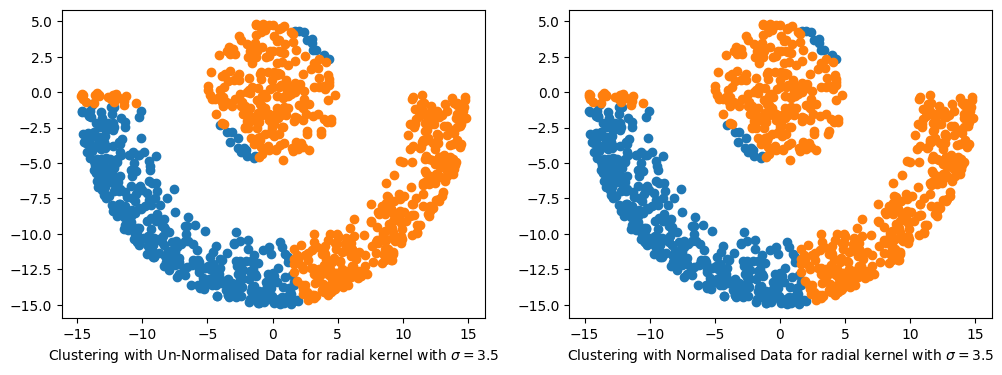

In [477]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i in range(num_clusters):
    axes[0].scatter(final_unnormalised_point_clusters[i][0], final_unnormalised_point_clusters[i][1])
    axes[1].scatter(final_normalised_point_clusters[i][0], final_normalised_point_clusters[i][1])

axes[0].set_xlabel(r"Clustering with Un-Normalised Data for radial kernel with $\sigma=$" + str(sigma))
axes[1].set_xlabel(r"Clustering with Normalised Data for radial kernel with $\sigma=$" + str(sigma))
# plt.savefig('images/Q2/p3rad3')
plt.show()

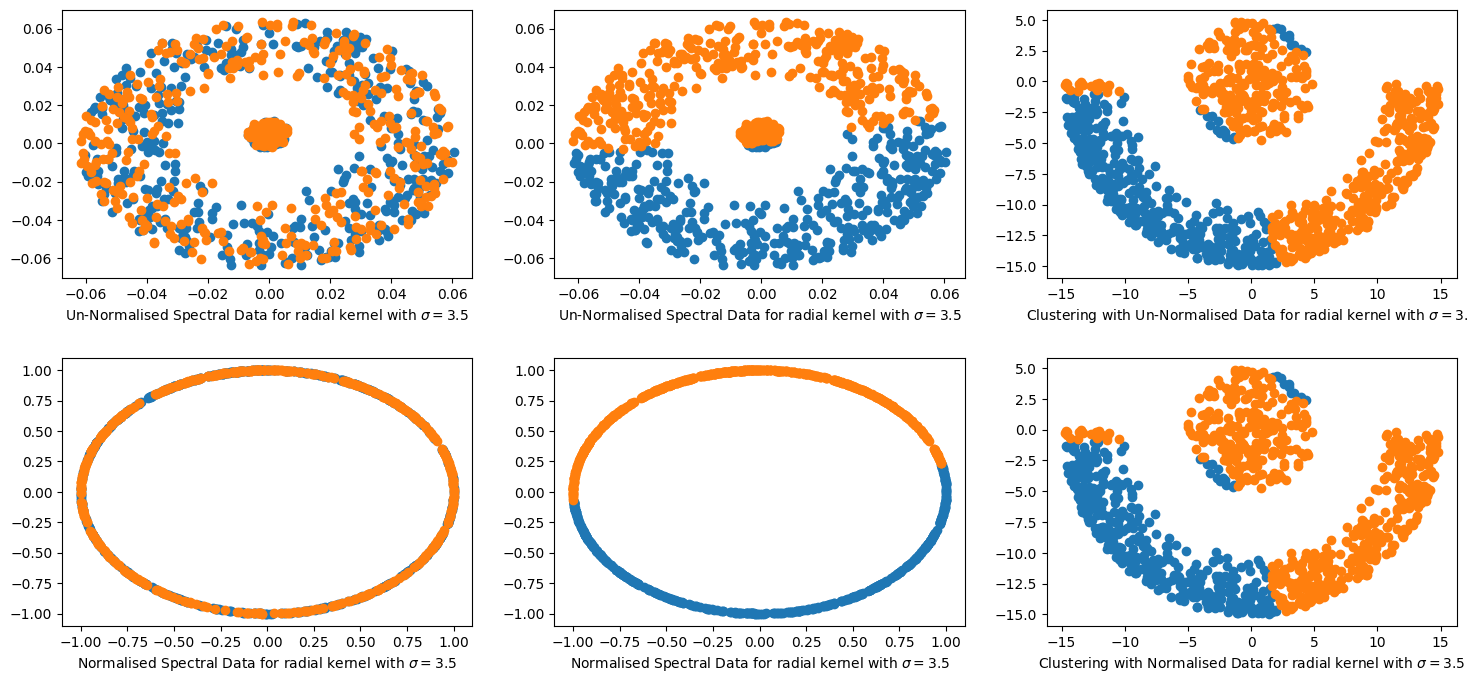

In [478]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
for i in range(num_clusters):
    axes[0][0].scatter(unnormalised_spectral_clusters[i][0], unnormalised_spectral_clusters[i][1])
    axes[0][1].scatter(final_unnormalised_spectral_clusters[i][0], final_unnormalised_spectral_clusters[i][1])
    axes[0][2].scatter(final_unnormalised_point_clusters[i][0], final_unnormalised_point_clusters[i][1])
    axes[1][0].scatter(normalised_spectral_clusters[i][0], normalised_spectral_clusters[i][1])
    axes[1][1].scatter(final_normalised_spectral_clusters[i][0], final_normalised_spectral_clusters[i][1])
    axes[1][2].scatter(final_normalised_point_clusters[i][0], final_normalised_point_clusters[i][1])


axes[0][0].set_xlabel(r"Un-Normalised Spectral Data for radial kernel with $\sigma=$" + str(sigma))
axes[1][0].set_xlabel(r"Normalised Spectral Data for radial kernel with $\sigma=$" + str(sigma))
axes[0][1].set_xlabel(r"Un-Normalised Spectral Data for radial kernel with $\sigma=$" + str(sigma))
axes[1][1].set_xlabel(r"Normalised Spectral Data for radial kernel with $\sigma=$" + str(sigma))
axes[0][2].set_xlabel(r"Clustering with Un-Normalised Data for radial kernel with $\sigma=$" + str(sigma))
axes[1][2].set_xlabel(r"Clustering with Normalised Data for radial kernel with $\sigma=$" + str(sigma))
fig.subplots_adjust(hspace=0.3)
# plt.savefig('images/Q2/p3rad')
plt.show()